# Линейная регрессия

Данные содержатся в файле `data/lin_reg.txt`. Прочитать их можно следующим так:

In [15]:
import numpy as np
D = np.loadtxt('lin_reg.txt', delimiter=',')
X = D[:, :-1]
Y = D[:, -1]

При выполнении заданий **нельзя** пользоваться `scikit-learn` и т.п., только `NumPy`/`JAX`/`TF`/`PyTorch` и `matplotlib`/`seaborn`/`plotly`/etc.

1. Нарисуйте график среднеквадратичной ошибки в зависимости от параметра регуляризации $\alpha$, используя полные данные для обучения и для тестирования. 
2. Подготовьте исходные данные для 5 fold CV.
3. С помощью CV найдите оптимальное значение $\alpha$ на какой-нибудь сетке значений.
4. Постройте валидационную кривую. 
5. Постройте кривую обучения.

In [16]:
import torch

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, shuffle=True, random_state=42)

dtype = torch.get_default_dtype()
t_X_train = torch.tensor(X_train, dtype=dtype)
t_y_train = torch.tensor(y_train, dtype=dtype)

t_X_test = torch.tensor(X_test, dtype=dtype)
t_y_test = torch.tensor(y_test, dtype=dtype)

In [18]:
class LinReg(torch.nn.Module):
    def __init__(self, ndim):
        super().__init__()
        self.w = torch.nn.Parameter(torch.randn(ndim, 1, requires_grad=True))
        self.b = torch.nn.Parameter(torch.randn(1,requires_grad=True))
    
    def forward(self, X):
        return (X @ self.w + self.b).view(-1)

In [51]:
alpha=0.1
nepoch = 3000

model = LinReg(t_X_train.shape[1])
optim = torch.optim.SGD(params=model.parameters(), weight_decay=alpha, lr=0.001)
floss = torch.nn.MSELoss()

train_losses = []
test_losses = []
for i in range(nepoch):
    optim.zero_grad()
    t_y_pred = model(t_X_train)
    loss = floss(t_y_train, t_y_pred)
    loss.backward()
    optim.step()
    if (i + 1) % 50 == 0:
        with torch.no_grad():
            t_y_pred_ = model(t_X_test)
            loss_ = floss(t_y_test, t_y_pred_)
            train_losses.append(loss)
            test_losses.append(loss_)


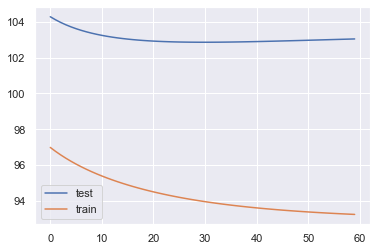

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()
ticks = np.arange(len(train_losses))

plt.plot(ticks, test_losses, label='test')
plt.plot(ticks, train_losses, label='train')
plt.grid(True)
plt.legend()

In [21]:
def KFold(size, n_splits=5, shuffle=True, random_state=None):
    idxs = np.arange(0, size)
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(idxs)
    splits = np.linspace(0, size, n_splits+1, dtype=np.int)
    for i in range(n_splits):
        yield (np.concatenate((idxs[0:splits[i]], idxs[splits[i+1]:])), idxs[splits[i]:splits[i+1]])# for i in range(n_splits))

In [38]:
train_losses = []
test_losses = []
nepoch = 5000
models = []
np.random
params = [0, 0.01, 0.05, 0.1, 0.5, 1]

for alpha in params:
    cv_train_losses = []
    cv_test_losses = []
    folder = KFold(np.shape(X)[0], n_splits=5, shuffle = True, random_state=42)
    
    for train_idx, test_idx in folder:
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = Y[train_idx], Y[test_idx]

        t_X_train = torch.tensor(X_train, dtype=dtype)
        t_y_train = torch.tensor(y_train, dtype=dtype)
        t_X_test = torch.tensor(X_test, dtype=dtype)
        t_y_test = torch.tensor(y_test, dtype=dtype)

        model = LinReg(t_X_train.shape[1])
        optim = torch.optim.SGD(params=model.parameters(), weight_decay=alpha, lr=0.001)
        floss = torch.nn.MSELoss()

        for i in range(nepoch):
            optim.zero_grad()
            t_y_pred = model(t_X_train)
            loss = floss(t_y_train, t_y_pred)
            loss.backward()
            optim.step()
            #if (i + 1) % 50 == 0:
            #    with torch.no_grad():
            #        t_y_pred_ = model(t_X_test)
            #        loss_ = floss(t_y_test, t_y_pred_)
            #        train_losses.append(loss)
            #        test_losses.append(loss_)
        with torch.no_grad():
            cv_train_losses.append(floss(t_y_train, model(t_X_train)))
            cv_test_losses.append(floss(t_y_test, model(t_X_test)))
    train_losses.append(torch.mean(torch.tensor(cv_train_losses, dtype=dtype)))
    test_losses.append(torch.mean(torch.tensor(cv_test_losses, dtype=dtype)))
    print(train_losses[-1], test_losses[-1])
    

tensor(94.8432) tensor(95.9980)
tensor(94.8547) tensor(95.9755)
tensor(94.9090) tensor(96.1268)
tensor(94.9978) tensor(96.0740)
tensor(95.7390) tensor(96.7766)
tensor(96.4409) tensor(97.3911)
